## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... 

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [59]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
# import pkg_resources
# pkg_resources.require("networkx==2.1")

  Using cached networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)


In [60]:
import networkx as nx
nx.__version__

'2.1'

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid_and_edges
import numpy.linalg as LA
%matplotlib inline 

In [62]:
plt.rcParams['figure.figsize'] = 12, 12

In [63]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [64]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [65]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [66]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

1895


Plot the edges on top of the grid along with start and goal locations.

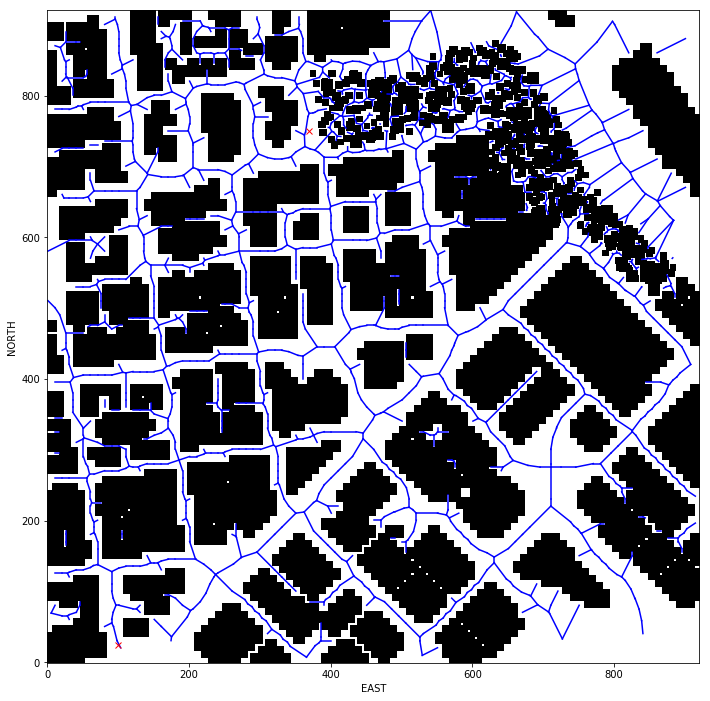

In [67]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [68]:
G = nx.Graph()

for e in edges:
    x1, y1 = e[0]
    x2, y2 = e[1]
    p1 = (x1, y1)
    p2 = (x2, y2)
    
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_node(p1)
    G.add_node(p2)
    G.add_edge(p1, p2, weight = dist)
    
print(G.number_of_nodes())
print(G.number_of_edges())

1965
1895


You need a method to search the graph, and you'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [69]:
from queue import PriorityQueue

def heuristic(p1, p2):
    return LA.norm(np.array(p2) - np.array(p1))

def a_star(graph, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 
4. Plot it up to see the results!

### TODO: Write your solution!

[our solution](/notebooks/Graph-Search-Solution.ipynb)

In [70]:
# Find closest point to a position
def closest_point(graph, current_point):
    closestPoint = None
    minDist = None
    for v in list(G.nodes):
        print(v)
        dist = heuristic([v[0], v[1]], [current_point[0], current_point[1]])
        print(dist)
        if minDist == None or dist < minDist:
            closestPoint = v
            minDist = dist
    return closestPoint

In [71]:
# Snap start/end positions to a node
start_ne_g = closest_point(G, start_ne)
goal_ne_g = closest_point(G, goal_ne)
print(start_ne_g)
print(goal_ne_g)

(860.7611, 860.7685)
1130.1616374950356
(880.7611, 900.7685)
1171.988588197624
(905.1728647058824, 797.8273235294118)
1123.2396205746938
(875.7611, 775.7685)
1086.4886169976471
(845.0918815402507, 745.0992815402507)
1043.409688095705
(853.9736449114224, 730.7685)
1041.6651115161624
(865.8633343429295, 706.6846606427216)
1036.878693243083
(882.8093899455806, 692.8167899455806)
1042.72177301531
(420.76110928574616, 908.2684766071934)
899.9582134188217
(445.7612000002501, 895.7683999997499)
900.1596157703435
(402.98335209876984, 888.5462879012302)
874.4579250179122
(398.5388572838606, 882.9906738270885)
867.5284855272075
(392.98336222222224, 878.5462777777778)
861.1306878250269
(810.7611, 205.7685000000001)
792.847704080336
(820.7611000000002, 200.7685)
802.1159634775138
(813.2611, 210.7685)
796.0057929220491
(580.7610999999999, 135.76850000000002)
556.9109317166076
(570.7610999999999, 137.43516666666667)
547.0434808829834
(732.8165084735704, 798.6639959940788)
994.5529593571828
(711.4274

198.5382021386192
(126.4753857142857, 240.7685)
173.53104764886615
(124.09443333333334, 237.43516666666667)
169.4347418752981
(148.03382727272728, 273.49577272727277)
212.6925146957663
(484.0944333333333, 180.76850000000002)
466.14509469681695
(476.21564545454544, 157.1321363636364)
454.818249093454
(460.7611, 160.76850000000002)
439.9778936099631
(473.61824285714283, 156.48278571428574)
452.1599638471725
(490.7611, 180.76850000000002)
472.71233627382736
(485.7611, 183.26850000000002)
468.22476906445263
(485.7611, 185.7685)
468.6758227874145
(490.7611, 190.76850000000002)
474.5232585084318
(410.76112, 150.76850000000002)
389.087499536935
(410.76112, 140.76850000000002)
387.90941248686454
(413.26112312500237, 163.26850562499925)
393.38226133661493
(380.76114, 174.10183333333336)
363.396574608871
(378.26114, 175.76850000000002)
361.29530667633867
(370.76114, 175.76850000000002)
353.96557957850877
(410.76112, 130.76850000000002)
386.9862301114917
(253.26107999985, 325.76848)
321.052218812

(613.9502422784462, 735.2806724305797)
866.2816635735112
(614.6999533686699, 735.4592711419459)
866.9224419077318
(618.6653606374481, 738.6412255623111)
871.9525075418512
(617.5180550212887, 760.8500529649592)
887.5812289756923
(615.5695063353706, 760.1120612176219)
885.731491580931
(797.7117178911052, 679.1377550264692)
965.6520793035769
(795.2673315121323, 681.9668393125087)
965.4000020997578
(795.4152685526736, 683.2140850023176)
966.2703322384367
(779.8132514813967, 707.482180505536)
968.9053845673884
(787.5539227171826, 695.6349438657119)
967.6101856663522
(785.8173989244758, 694.578553624615)
965.5914099330752
(750.0220302952296, 711.4169227890283)
948.4131999746847
(748.6748176522821, 711.196979985908)
947.2417801427248
(763.5510252876479, 607.1036637896611)
895.8860099266724
(763.4708215466205, 607.131357653134)
895.8355698401641
(777.581547594978, 585.9469863519919)
895.8367369811506
(777.6978132681156, 581.3826210549454)
893.4669697041588
(754.8421277914291, 600.7685)
885.120

431.8904901218887
(212.7611184000013, 490.76846)
433.536880684436
(175.7611, 490.76846)
418.84233143747736
(175.7611, 485.768470000005)
414.1813874612846
(278.761139999998, 478.76845999999796)
455.9169468936954
(272.761136, 482.768466)
455.95754086976524
(219.0944511111126, 510.76846)
454.31639160709983
(230.76111499998, 510.76846)
459.4217715529017
(217.90397877550927, 503.6256212244907)
447.3539841515645
(246.76114539999378, 506.76845640000414)
463.2910345896619
(280.7611415937501, 420.7684641562499)
410.2513487442761
(280.7611394375, 420.7684605625)
410.2513445901238
(270.7611390625, 410.76846093750004)
396.2014308237162
(270.76113437499623, 410.76845812499795)
396.2014257100466
(78.7611, 288.7685)
196.27481362992046
(20.7611, 550.7685)
450.78843027018786
(9.991858934911413, 529.2300178698229)
429.49231953407275
(75.7611, 485.76846)
389.0938113154482
(92.52580755190294, 461.9449360640142)
368.18999365534086
(90.76109375000064, 460.76846)
366.7129711122419
(92.42777111111573, 462.435

810.8059687647791
(776.7546525981404, 417.6663328744886)
816.1169994215758
(776.357865591847, 401.42840704201456)
809.5663819345654
(790.9908167916197, 403.7106269672359)
824.003687092433
(789.6709568753926, 404.7794608630338)
823.1720306550084
(762.3414398968858, 401.68347959722547)
796.6714007990387
(761.0584004897765, 400.5778463048267)
795.0654127936999
(570.7610999999999, 170.76850000000002)
550.3302271050173
(635.7610999999999, 300.7685)
642.912989342617
(610.7610999999999, 280.7685)
613.0198339902714
(390.76114, 670.7685)
677.9069937139973
(580.7610999999999, 560.7685)
721.926596590997
(315.7611353333279, 635.7685093333442)
609.5817692595471
(340.76114, 620.7685083333317)
609.0196522328512
(390.7611974999563, 520.7685174999563)
557.518967314757
(380.76114, 510.76846)
543.4121055560606
(370.76114, 500.76846)
529.3072118013047
(340.76114, 500.76845849999995)
510.2160864404079
(550.7610999999999, 690.7685)
790.8426865473689
(540.7610999999999, 680.7685)
776.7248952270423
(422.76114

112.96354223678101
(630.7610999999999, 400.768465)
123.14468608781395
(620.7610999999999, 400.768465)
132.851013212795
(743.472749578807, 500.389587991517)
130.55286153378069
(743.8077007489293, 500.4228465404419)
130.56976476093718
(880.7611, 514.8606717272826)
195.1488649377432
(890.7611, 519.3269941348248)
205.21266639891408
(905.7611, 528.2033734522258)
222.01312493831182
(905.7611, 475.76846)
188.27768695196363
(848.4567918742238, 470.76846)
140.88300961058368
(918.4145525860771, 662.2823342483026)
337.3313273865993
(887.0257980745135, 687.8909684289295)
346.1657654168592
(898.7845381915547, 654.78118251002)
321.30540100763875
(874.2677466946061, 640.462241953292)
297.6445819949624
(838.1402075043337, 745.6423901902941)
385.8444006160828
(830.7610999999999, 748.2643497307893)
386.7897019705499
(814.7553880080085, 698.3151877001985)
334.64028859461064
(821.5472323184023, 750.6629852847866)
387.328432752295
(789.0811488450678, 708.522654943318)
340.7710728699299
(802.2079997097569, 

(370.761145, 305.76850125)
384.6398244765904
(380.761145, 310.768505)
373.9594925144247
(390.76114, 300.7685)
365.84909337915485
(380.76114, 304.10183333333333)
375.07319832817615
(300.76113945, 260.76852279998764)
462.327880880614
(297.4277874166553, 250.76847213331726)
468.0147057946018
(630.7610999999999, 140.76850000000002)
258.3892332614887
(688.2610999999999, 260.7685)
125.47195848260282
(670.7610999999999, 260.7685)
134.94563299884885
(702.1896714285714, 279.3399285714285)
102.49427334998599
(704.0944333333333, 284.10183333333333)
97.3951543336845
(690.7610999999999, 290.7685)
98.92865037722896
(695.7610999999999, 240.7685)
140.15219893194686
(693.2610999999999, 250.7685)
132.04337683299383
(665.7610999999999, 260.7685)
137.94097602039795
(660.7610999999999, 250.7685)
148.92861332014078
(780.7610999999999, 290.7685)
84.99338718665113
(770.7610999999999, 292.7685)
79.97329470179402
(794.9594749607235, 461.64296922846785)
102.07736378724631
(793.68592709143, 458.744484016055)
98.9

(812.5168023424278, 352.52421585389965)
64.91343163508827
(791.8840603441948, 432.99447536515004)
75.64772592382833
(791.3995666920595, 432.12021219220543)
74.65148950352503
(790.4268443570307, 431.2396667710903)
73.3800145196345
(743.0835722060158, 409.2139272718669)
39.81920473229801
(748.8264168189972, 404.03368702902384)
34.053915344234326
(736.9875456663934, 407.63312948631574)
39.8192968636816
(749.8125740616871, 401.5395525041531)
31.540109394936838
(770.7610999999999, 310.7685)
62.76459085710665
(800.7610799999999, 340.76848)
58.57618120257403
(495.76115000000004, 325.76855000000006)
258.05777263710735
(495.76115, 325.76845000000003)
258.05778977726095
(480.7611, 290.7685)
280.65497655566344
(470.7611, 290.7685)
290.2619400911184
(490.7611, 287.4351666666667)
272.0694010295371
(494.7611, 284.7685)
269.0934868506854
(660.7610999999999, 263.2685)
139.12294694068268
(635.7610999999999, 265.7685)
154.64388725539723
(650.7610999999999, 265.7685)
143.91860500109084
(580.7610999999999

(500.7610999999999, 610.7685)
346.53931936428233
(466.4753857142857, 590.7685)
359.3395852089122
(467.4277666666667, 594.1018333333334)
360.65038299487344
(474.0944333333333, 607.4351666666666)
364.004588003616
(461.7610929600013, 579.7684718400052)
356.489101249539
(450.7611, 575.0541918367361)
362.7549322380427
(461.7611, 579.7685)
356.48911212750943
(380.76114750000124, 660.7685075000012)
469.9826115392931
(370.7611487500009, 650.7685012499991)
471.8612694337072
(400.76114, 558.2684937499987)
396.75282868934016
(385.761145000005, 565.768494999995)
413.5157156944225
(377.4278066666667, 574.1018333333334)
424.81478036344083
(376.76114, 576.7685)
426.68543355304456
(615.7610999999999, 590.7685)
258.37726847666
(615.7610999999999, 595.7685)
262.66232669619757
(678.5491892046318, 670.1206552770908)
308.50871314642944
(678.0278259527604, 663.3226183601383)
302.023430016172
(685.7610999999999, 590.7685)
229.92469825023153
(685.7610999999999, 580.7685)
220.340638252366
(685.7610999999999, 5

688.2862125309753
(85.7611, 390.76846)
664.5634997530196
(80.7611, 390.76846)
669.5610757832192
(115.7611, 545.7685)
658.1440175717319
(115.7611, 545.76846000008)
658.1440068890772
(344.5111366406253, 608.2684951562503)
470.3116988684225
(340.76114, 600.7685015000001)
469.81969500932496
(325.76113945, 565.76849945)
467.23004631302024
(140.7611, 155.76850000000002)
645.807380621699
(130.7611, 160.76850000000002)
653.6318810044841
(145.7611, 170.76850000000002)
636.2372504541526
(145.7611, 180.76850000000002)
633.1770754421389
(143.2611, 160.76850000000002)
641.8020827057669
(230.76114, 194.10183333333333)
548.2236393761162
(240.76114, 190.76850000000002)
539.8593771773809
(280.76114, 140.76850000000002)
522.2376741736942
(277.42780055555187, 130.76848166665562)
529.6755639557488
(744.3241754723113, 659.2727195417946)
289.32839690423555
(745.5171660543552, 659.5453637210301)
289.5800639763169
(743.8284769923446, 659.2320545031267)
289.29788980967993
(740.6284900000991, 656.6628638066044)

In [72]:
# Use A* to compute path along the graph
path, cost = a_star(G, heuristic, start_ne_g, goal_ne_g)
print(len(path))

Found a path.
97


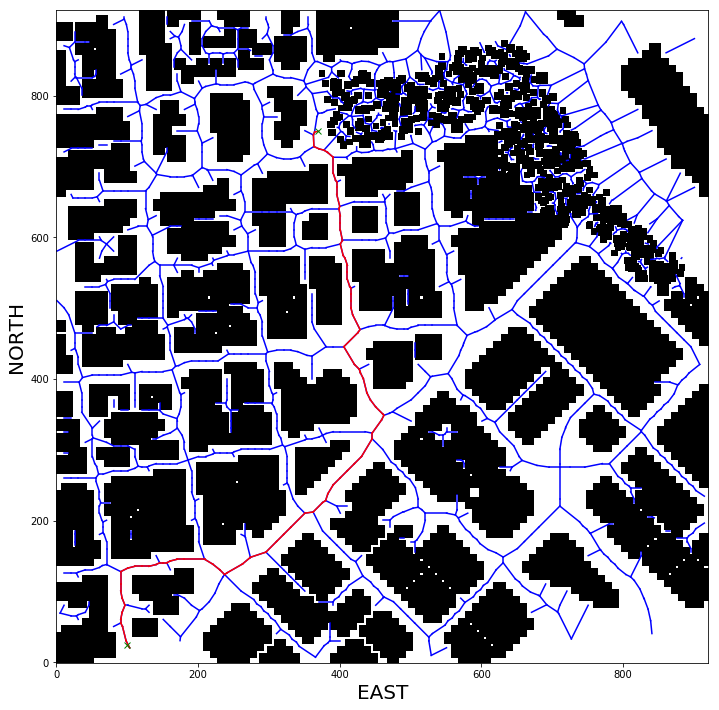

In [73]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')
    
plt.plot(start_ne[1], start_ne[0], 'gx')
plt.plot(goal_ne[1], goal_ne[0], 'gx')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()